## Ejercicio 1 del libro The Elements

Revisado por BP el 18-07-19 y desarrollado por AC el 24-07-19

Primero que todo, vamos a dejar todos los import en la cabezera del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image

### Predicción del color asociado a un set de puntos distribuidos en un espacio de dimensión dos

Basicamente, debemos encontrar la funcion F: R²-> R, que me lleva desde un espacio de dos dimensiones, asociado con la posicion de los puntos en 2D, a un espacio unidimensional, donde el valor de salida de la funcion se puede asociar con un color segun su valor númerico. Por ejemplo, suponiendo que el valor de salida F(x) se restringe al intervalo [0,1] podemos asociar el color azul para F(x) < 0.5 y el color naranjo para F(x) < 0.5, en cuyo caso tendriamos solo dos colores para predecir.

Los datos del entrenamiento son dados de tal forma que los puntos distribuidos en 2D solo pueden adquirir dos valores posibles, y = 0 o y = 1. En términos de la condición anterior el primer valor representa el color azul y el segundo el color naranjo. 

En una primera aproximacion de la funcion F(x) utilizaremos una regresion lineal, que dependera de tres parametros libres agrupados en el vector beta = (beta0, beta1, beta2). De hecho podemos escribir explicitamente nuestra aproximacion para F(x) como

F(x1, x2, beta) = beta0 + x1 * beta1 + x2 * beta2

Por lo tanto asumiremos que nuestra prediccion F(x) puede tomar valores continuos en R. El valor de F(x1,x2,beta) se debe comparar con los valores de y del set de entrenamiento. En un segundo paso minimizaremos el valor de la suma de los residuos al cuadrado, RSS(beta), comparando nuestra función F(x1,x2,beta) con los valores discretos de y del set de entrenamiento. 

### Pasos:
- Simular los datos a utilizar, lo cuales se producirán a partir de dos gaussianas bivariadas y una funcion llamada SIMULADOR()
- Generar las funciones básicas para llevar a cabo una regresión lineal, en base a los datos simulados
- Aplicar las funciones generadas (RSS() , FindMinimum() y f ()) a los datos simulados en el primer paso

### I) SIMULACIÓN DE DATOS

### Distribución Normal Bivariada

Una distribución normal bivariada, también llamada distribución gaussiana bivariada, es una generalización de la distribución normal unidimensional a dos dimensiones, como vemos a continuación:

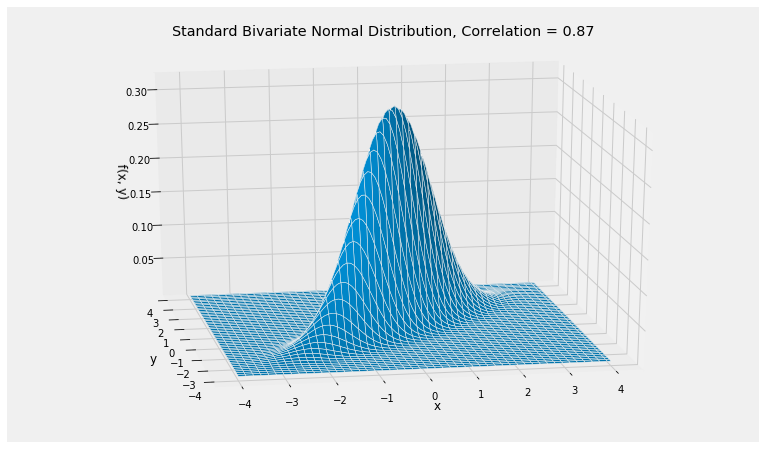

In [2]:
Image("bivariate.png")

### Generación de la función SIMULADOR()

### BP: Nueva interpretación de los ouputs de la función SIMULACION

Dado las indicaciones en la pagina 16 del libro, se puede entender que el proceso de simulación del set de datos de entrenamiento es el siguiente.

1- Primero se escoge el color a simular 

2- Dado el color, conocemos el centro y la matriz de covarianza de una gaussiana bivariada

3- Con esta gaussiana bivariada generamos 10 centros. Esto lo hacemos solo una vez porque nos permite generar las observaciones asociadas a un set fijo de gaussianas bivariadas, 10 en nuestro caso. La idea de la simulación parece ser, ahora que lo veo mas detenidamente, generar observaciones que representen instancias asociados a un set de gaussianas bivariadas, no con respecto a una sola de ellas  

4- Con estos valores de los centros, mas una covarianza fija igual a la identidad/5, podemos asumir que conocemos los parametros de 10 gaussianas bivariadas

5- Considerando estas 10 gaussianas bivariadas podemos generar nuestras observaciones

6- Cada observacion se genera de la siguiente forma:

    1- Se escoge uno de los centros dados anteriormente y su gaussiana bivariada correspondiente
    2- Se genera un valor de la posicion siguiendo esta gaussiana bivariada   
    3- Se vuelve a 6.1 y se repite el proceso, 100 veces por cada color

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_azul

array([[ 1.18131225,  1.38526082,  1.8084645 ,  0.90970942,  2.40179523,
         1.6156396 ,  1.00349799,  2.53435211, -0.01424951,  0.44833095],
       [ 0.36041841, -0.13036043,  1.19641344,  1.441326  , -0.96696092,
         0.24230438, -1.40824018,  0.86641243, -0.81787229,  1.19684959]])

In [4]:
centros_rojo = centros_asociados_a_cada_color(1,10)
centros_rojo

array([[-0.73602763, -0.26064202,  2.13381066, -0.66524148, -2.74906434,
        -1.21262174,  0.5788061 ,  1.63940106, -1.60715108, -0.10832288],
       [ 1.81119389,  3.20959174,  0.97328238,  1.48319219,  0.32118354,
         0.52628849,  2.65423861,  1.64022342,  1.86579176,  0.20970414]])

In [5]:
centros_azul.shape

(2, 10)

In [6]:
centros_azul[0]

array([ 1.18131225,  1.38526082,  1.8084645 ,  0.90970942,  2.40179523,
        1.6156396 ,  1.00349799,  2.53435211, -0.01424951,  0.44833095])

Algunas veces es conveniente definir funciones para visualizar de manera general

In [7]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-5,5,-5,5])
    plt.title("Distribucion de puntos segun el color")
    plt.show()

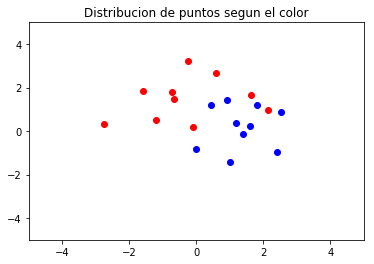

In [8]:
visualize_colors(centros_azul, centros_rojo)

Ahora implementamos una funcion simulacion que considere como input los centros generados anteriormente y en torno a estos centros se generaran N observaciones

In [9]:
def Simulacion_2(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Initialize the list of observations 
    observations = np.zeros((2,N))
    
    #we first define the global value of the covariance
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N-1 para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre 0 y 9 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

Ahora generamos 100 observaciones por cada color, asociado a las 10 gaussianas bivariadas correspondientes

In [10]:
ptos_observados_azul =  Simulacion_2(centros_azul, 100)
ptos_observados_rojo =  Simulacion_2(centros_rojo, 100)

In [11]:
print(ptos_observados_azul.shape, ptos_observados_rojo.shape)

(2, 100) (2, 100)


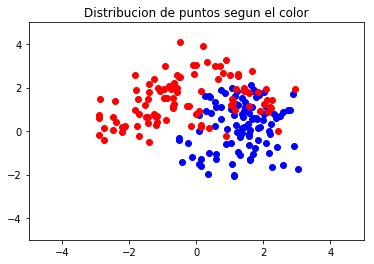

In [12]:
visualize_colors(ptos_observados_azul, ptos_observados_rojo)

Creo que esta distribucion se asemeja mas a los mostrado en el libro. Ademas si generamos mas puntos la evolucion
sera mas estable dado que los 10 centros de cada color seran los mismos siempre. Si decidimos seguir con esta forma de simular los datos podriamos borrar lo que viene mas abajo para evitar confusiones. Por ahora lo podemos dejar para ir comparando donde aparecen las diferencias

Ahora me paso a la parte de la regresion lineal usando estos datos de la simulacion

## II) FUNCIONES PARA GENERAR LA REGRESIÓN LINEAL

### Teoría: Regresión lineal (revisado)

El modelo lineal es una herramienta muy poderosa e importante en estadística. Si suponemos que tenemos un vector de inputs con p variables,de la forma: $$X^T = (X_1 , X_2 , ... , X_p)$$ damos una predicción del valor de Y mediante el modelo lineal de la siguiente forma:
$$\hat{Y}=\beta_0 + \sum_{i=1}^p x_i \beta_i = \sum_{i=0}^p x_i \beta_i$$

A este modelo le llamamos lineal, en el sentido de que el polinomio utilizado para la prediccion es lineal en los argumentos X. El término constante es conocido como el coeficiente de intersección o el bias. Esta constante puede ser introducida a la sumatoria si formamos un x_0 = 1, lo que generará que el vector X tendrá (p+1) dimensiones. 

En nuestro ejercicio en particular vamos a considerar dos dimensiones para X, por lo tanto deberiamos pensar que p+1 = 3 y por lo tanto p = 2. Sin embargo, debemos ser muy cuidadosos al seguir el libro, especialmente las ecuaciones 2.3-2.6, dado que el vector X ya tiene dimension 3, pero el libro menciona que X es una matriz de Nxp, lo cual es incosistente con p=2. Por lo tanto vamos a considerar que X en estas ecuaciones tiene dimension Nx3 y no hablaremos mucho mas del valor de p.  

Para ajustar el modelo lineal a los datos, el método más popular que se utiliza es el de los mínimos cuadrados, el cual se basa en escoger los coeficientes beta que minimizan la función de la suma de los residuos cuadráticos RSS():
$$ RSS(\beta) = \sum_{i=1}^N (y_i - x_i ^T \beta)^2$$
En donde N indica el número de puntos que tenemos, los que son de la forma (x_1 , y_1),...,(x_N , y_N).
Utilizando notación matricial podemos escribir a RSS() como:
$$ RSS(\beta) = Tr[(Y - X\beta)^T(Y - X\beta)]$$
En donde, en nuestro caso, Y es un vector de N dimensiones, X tiene (N * 3) dimensiones y beta 3 dimensiones.
 
Finalmente, para encontrar los coeficientes del vector beta debemos derivar RSS() con respecto a esta variable y luego igualar a 0, con lo que se obtiene que:
$$\hat{\beta} = (X^T X)^{-1}X^T Y$$

### Primero, vamos a crear los sets de puntos X e Y 

Para esto voy (BP) a utilizar tus funciones (AC) hasta donde pueda, pero creo que tendre que ir agregando cosas. 

In [13]:
SET=[]

#Notar que estoy (BP) utilizando los puntos generados con la distribucion de gaussianas mezcladas. Ademas, 
#vamos a agregar directamente el valor de x0 al SET, por lo mencionado anteriormente. Ver notas adjuntas

#primero agregamos los vectores correspondientes a la distribución gaussiana azul (y=0) a la lista SET. 
x1azul = ptos_observados_azul[0,:]
x2azul = ptos_observados_azul[1,:]

x1rojo = ptos_observados_rojo[0,:]
x2rojo = ptos_observados_rojo[1,:]

for i in range(len(x1azul)):
    SET.append([1,x1azul[i],x2azul[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo)):
    SET.append([1,x1rojo[i],x2rojo[i],1])

Ahora hacemos un par de tests para verificar lo que almacenamos en SET

In [14]:
ptos_observados_azul[:,0]

array([ 1.56402199, -0.65143227])

In [15]:
SET[0]

[1, 1.5640219924459888, -0.6514322688184057, 0]

In [16]:
ptos_observados_rojo[:,-1]

array([1.01777255, 2.58032679])

In [17]:
SET[-1]

[1, 1.0177725483685465, 2.5803267899166276, 1]

In [18]:
print(len(SET))

200


Ok, entonces SET es una lista de largo N=200 con tres entradas por observacion. 

### Ahora intentamos calcular el valor teorico de beta usando este SET

In [19]:
X=[]

#notice that now we have to put SET[i][1] y SET[i][2] en las componentes x1 y x2 de X
#on the other hand Y = SET[i][3]
for i in range(len(SET)):
    X.append([1,SET[i][1],SET[i][2]])

Y=[]
for i in range(len(SET)):
    Y.append(SET[i][3])

#esto lo hice porque la función transpose() necesitaba un array y no una lista 
#BP: excelente, yo hago esto todo el rato, pasarme de listas para nparray y viceversa. Solo hay que ir
#revisando para no confundirse
    
X=np.array(X)                     
Y=np.array(Y)

XT=X.transpose()

In [20]:
print(X.shape, Y.shape, XT.shape)

(200, 3) (200,) (3, 200)


In [21]:
XTdotX = np.dot(XT,X)
XTdotX

array([[200.        ,  99.23109356, 163.72484014],
       [ 99.23109356, 477.89862506,  41.39201409],
       [163.72484014,  41.39201409, 426.11885773]])

In [22]:
XTdotX_inversa = np.linalg.inv(XTdotX)
XTdotX_inversa

array([[ 0.00816722, -0.00143613, -0.00299853],
       [-0.00143613,  0.00236278,  0.00032228],
       [-0.00299853,  0.00032228,  0.00346756]])

In [23]:
np.dot(XTdotX, XTdotX_inversa)

array([[ 1.00000000e+00,  6.93889390e-18,  0.00000000e+00],
       [-1.38777878e-17,  1.00000000e+00,  2.77555756e-17],
       [ 0.00000000e+00, -2.77555756e-17,  1.00000000e+00]])

In [24]:
XTdotX_inversa_dotXT = np.dot(XTdotX_inversa, XT)

### Valores teoricos de beta

In [25]:
beta_teorico = np.dot(XTdotX_inversa_dotXT,Y)
print(beta_teorico)

[ 0.44214395 -0.18001961  0.17978184]


In [26]:
beta_teorico.shape

(3,)

Con estos valores de beta teorico podemos evaluar la funcion prediccion

In [27]:
def funcion_lineal(x1, x2, beta): 
    
    y_prediccion = beta[0] + x1*beta[1] + x2*beta[2]
    return y_prediccion  

In [28]:
funcion_lineal(0.2,0.2, beta_teorico)

0.44209639440594767

Para evaluar las predicciones de la funcion lineal, incialmente consideramos las posiciones guardadas en SET. Sin embargo, en general podemos evaluar cualquier otro punto del espacio 2D. De hecho esta es la gracia de obtener los valores de beta y la forma explicita de la funcion de regresion, que puede ser evaluada en puntos que no estaban en el set de entrenamiento. 

Ademas, para obtener una representacion visual de los resultados de nuesta prediccion vamos a separar los puntos entre azules y rojos considerando un valor de corte de 0.5, puesto que los valores del entrenamiento pueden ser 0 o 1 solamente (menor o mayor que 0.5)

In [29]:
len(SET)

200

In [30]:
lista_de_predicciones_azul = []
lista_de_predicciones_rojo = []

for pto in range(len(SET)):
    
    #prediccion de la funcion lineal como funcion de la posicion en el plano 2d y el valor teorico de beta
    #el cual se encontro minimizando algebraicamente RSS()

    prediccion = funcion_lineal(SET[pto][1], SET[pto][2], beta_teorico)

    #Utilizando el valor de la prediccion separamos entre puntos azules y rojos
    
    if (prediccion < 0.5):
        lista_de_predicciones_azul.append([SET[pto][1], SET[pto][2]])
    else:
        lista_de_predicciones_rojo.append([SET[pto][1], SET[pto][2]])

Para usar la misma funcion visualizacion que antes debemos manipular estas listas un poco

In [31]:
lista_de_predicciones_azul = np.array(lista_de_predicciones_azul)
lista_de_predicciones_azul.shape

(105, 2)

In [32]:
lista_de_predicciones_azul_t = lista_de_predicciones_azul.transpose()
lista_de_predicciones_azul_t.shape

(2, 105)

In [33]:
lista_de_predicciones_rojo = np.array(lista_de_predicciones_rojo)
lista_de_predicciones_rojo_t = lista_de_predicciones_rojo.transpose()
lista_de_predicciones_rojo_t.shape

(2, 95)

Ahora, podemos comparar visualmente el sample de entrenamiento con el sample de predicciones

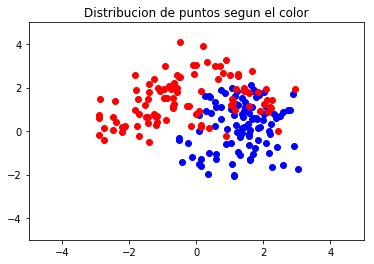

In [34]:
visualize_colors(ptos_observados_azul, ptos_observados_rojo)

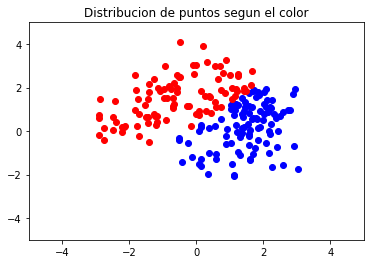

In [35]:
visualize_colors(lista_de_predicciones_azul_t, lista_de_predicciones_rojo_t)

Ambas distribuciones se parecen pero no son identicas. Podemos notar que la separacion entre los puntos azules y rojos es una linea recta, lo cual se debe a la aproximacion lineal que estamos haciendo. Sin embargo no debemos confundir esta linea recta con la forma de la funcion de regresion que estamos utilizando puesto que esta es de hecho mejor representada por un plano en tres dimensiones (meditar al respecto)

## Finalmente, la idea es calcular el valor de beta numericamente

Pero lo haremos en otro momento... Lo que esta bajo este modulo no ha sido revisado acusiosamente, aunque ya he tomado algunas cosas para implementar la solucion teorica de mas arriba

AC:
Para calcular el valor del vector beta numericamente (utilizando el método de búsqueda de Monte Carlo) creamos las funciones RSS(SET,beta) y FindMinimum(SET, intentos,beta).

#### Comenzamos con la función RSS(SET,beta):

In [36]:
###-----------------------------------------------------------------------------------------------------------------------------
#DESCRIPCIÓN : RSS es la suma de los residuos al cuadrado, es decir (y - y_predicción)^2. Me indica que tan buenas están las 
#              predicciones
#¿QUÉ RECIBE? : recibe, en nuestro caso, el SET de dimensiones 200 x 4 y el vector beta             
#¿QUE RETORNA? : retorna la suma total residual al cuadrado para todo punto.
#Datos: SET[i][3]= y , SET[i][0] = x0_i , SET[i][1] = x1_i , SET[i][2] = x2_i

def RSS(SET,beta):                    #set es una matriz de 200 x 4 y beta un vector de 1 x 3
    SUM=0 
    n=len(SET)                            #en nuestr0 caso el largo del set es 200 
    for i in range(n):
        SUM= SUM + ( SET[i][3] - funcion_lineal(SET[i][1], SET[i][2], beta))**2 
    return SUM

#### Ahora vemos la función FindMinimum(SET,intentos,beta)

In [41]:
###-----------------------------------------------------------------------------------------------------------------------------
#DESCRIPCIÓN : FindMinimum() encuentra los valores del vector beta (b0, b1 y b2) para los cuales la función
#              RSS() se hace mínima.
#¿QUÉ RECIBE? : recibe al SET de 200 x 4, el cual es de la forma: [x0_i , x1_i, x2_i, y_i], el número de intentos
#               o repeticiones que se harán y el vector beta (que tendrá los valores de b0,b1 y b2 obtenidos teóricamente)
#¿QUÉ RETORNA? : retorna los b0, b1 y b2 que logran que la función RSS() obtenga su valor mínimo.También retorna el valor mínimo
#                que toma esta función.

def FindMinimum(SET,intentos,beta_teorico):
    minimum=10000               #Asignamos un valor inicial grande a minimum, para que haya una cota superior difícil de siperar
    for i in range(intentos):
        b0_numerico = np.random.uniform(beta_teorico[0] - 0.5 , beta_teorico[0] + 0.5)    #Como ya conocemos los valores de beta
        b1_numerico = np.random.uniform(beta_teorico[1] - 0.5 , beta_teorico[1] + 0.5)    #teórico, los podemos usar para 
        b2_numerico = np.random.uniform(beta_teorico[2] - 0.5 , beta_teorico[2] + 0.5)    #acotar el rango de búsqueda (+-0.5)
        nuevo_beta=np.array([b0_numerico,b1_numerico,b2_numerico])                                                   #y con esto converger a la solución 
        prueba=RSS(SET,nuevo_beta)                                                        #correcta con mayor velocidad
        if prueba < minimum:
            minimum = prueba
            beta_min=nuevo_beta
    return minimum,beta_min


In [47]:
valores_numericos = FindMinimum(SET,100,beta_teorico)
print(valores_numericos)

(25.941494346610654, array([ 0.46787458, -0.16374488,  0.22895244]))


In [52]:
beta_numerico = valores_numericos[1]
print(beta_numerico)

[ 0.46787458 -0.16374488  0.22895244]


Ahora comparamos con los valores beta_teorico y la función RSS(SET, beta_teorico)

In [39]:
RSS(SET,beta_teorico)

24.088612648654113

In [40]:
beta_teorico

array([ 0.44214395, -0.18001961,  0.17978184])

Vemos que el valor de RSS() al utilizar el beta_teorico es más pequeño que el obtenido con el beta_numérico. Lo lógico sería pensar que ahora si aumentamos el número de intentos, este valor debería acercarse más al valor obtenido teóricamente. Probemos con 1000 intentos 

In [45]:
FindMinimum(SET,1000,beta_teorico)

(24.163482409963652, array([ 0.45291687, -0.1805521 ,  0.18753884]))

Ok, vemos que efectivamente al aumentar el número de intentos, el valor del beta_numérico se acerca mucho más al beta_teórico.
Ahora vemos la predicción que genera este beta_numerico: 

In [53]:
lista_azul_numerico=[]
lista_rojo_numerico=[]
for punto in range(len(SET)):
    prediccion = funcion_lineal(SET[punto][1],SET[punto][2],beta_numerico)
    if prediccion < 0.5:
        lista_azul_numerico.append([SET[punto][1],SET[punto][2]])
    else:
        lista_rojo_numerico.append([SET[punto][1],SET[punto][2]])

Ahora utilizamos la función de visualización generada por BP:

In [69]:
lista_azul_numerico = np.array(lista_azul_numerico)
lista_azul_numerico_t = lista_azul_numerico.transpose()
lista_rojo_numerico = np.array(lista_rojo_numerico)
lista_rojo_numerico_t = lista_rojo_numerico.transpose()


Ahora veamos visualmente la comparación entre la muestra de entrenamiento y la muestra de predicción:

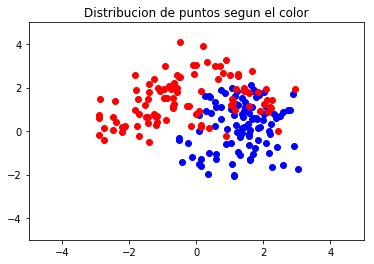

In [70]:
visualize_colors(ptos_observados_azul, ptos_observados_rojo)

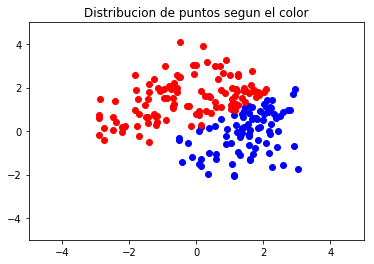

In [71]:
visualize_colors(lista_azul_numerico_t,lista_rojo_numerico_t)

Y ahora también podemos comparar la visualización de las muestras de predicciones obtenidas con el beta_teorico o con el beta_numerico:

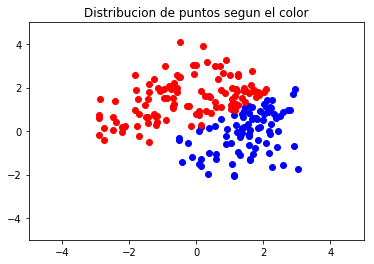

In [74]:
visualize_colors(lista_azul_numerico_t,lista_rojo_numerico_t)

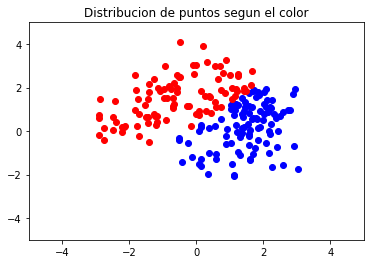

In [73]:
visualize_colors(lista_de_predicciones_azul_t, lista_de_predicciones_rojo_t)